# 量化计算机视觉分类

{guilabel}`来源`：[quantized_transfer_learning](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html)
   
```{admonition} 任务
使用量化模型提取特征。
```

## 准备

在进入迁移学习之前，让我们回顾一下“先决条件”，例如安装和数据加载/可视化。

详细内容见：{doc}`图像分类的迁移学习 <basic>`。

In [1]:
from matplotlib import pyplot as plt
import torch
from torchvision.models.quantization import resnet18

from mod import load_mod

plt.ion()
# 载入自定义模块
load_mod()

from pytorch_book.datasets.examples import Hymenoptera
from xinet import ModuleTool, CV

In [2]:
loader = Hymenoptera()

## 1 基于量化特征提取器训练自定义分类器

在本节中，将使用“冻结”的量化特征提取器，并在此基础上训练自定义分类器头部。与浮点模型不同，您不需要为量化模型设置 `requires_grad=False`，因为它没有可训练的参数。请参阅 [文档](https://pytorch.org/docs/stable/quantization.html) 了解更多细节。

加载预训练模型：在这个练习中，使用 [ResNet-18](https://pytorch.org/hub/pytorch_vision_resnet/)。

In [3]:
# 我们需要 `fc` 中过滤器的数量，以便将来使用。
# 这里每个输出样本的大小设置为 2。
# 或者，它可以推广到 nn.Linear(num_ftrs, len(class_names))。
model_fe = resnet18(pretrained=True, progress=True, quantize=True)

/home/pc/xinet/anaconda3/envs/ai/lib/python3.9/site-packages/torch/ao/quantization/observer.py:172: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


此时，您需要修改预训练的模型。该模型在开始和结束都有量化/反量化块。但是，因为你只会使用特征提取器，所以反量化层必须在线性层（头部）之前移动。最简单的方法是将模型封装在 ``nn.Sequential`` 模块中。第一步是分离 ResNet 模型中的特征提取器。虽然在这个例子中，你的任务是使用除 ``fc`` 以外的所有层作为特征提取器，但实际上，你可以根据需要取尽可能多的部分。如果您也想替换一些卷积层，这将是有用的。

```{note}
当将特征提取器与量化模型的其余部分分离时，您必须手动将 quantizer/dequantized 放置在希望保持量化的部分的开头和结尾。
```

下面的函数创建一个带有自定义头部的模型。

In [4]:
from torch import nn


def create_combined_model(model_fe):
    num_ftrs = model_fe.fc.in_features
    # 步骤1：分离特征提取器
    model_fe_features = nn.Sequential(
        model_fe.quant,  # 量化 input
        model_fe.conv1,
        model_fe.bn1,
        model_fe.relu,
        model_fe.maxpool,
        model_fe.layer1,
        model_fe.layer2,
        model_fe.layer3,
        model_fe.layer4,
        model_fe.avgpool,
        model_fe.dequant,  # 反量化 output
    )

    # 步骤2：创建一个新的“头”
    new_head = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 2),
    )

    # 步骤3：合并，不要忘记量化 stubs
    new_model = nn.Sequential(
        model_fe_features,
        nn.Flatten(1),
        new_head,
    )
    return new_model

```{warning}
目前，量化模型只能在 CPU 上运行。然而，可以将模型的反量化部分发送给 GPU。
```

In [5]:
import torch.optim as optim
new_model = create_combined_model(model_fe)

device = 'cpu'
train_iter = loader.dataloaders['train']
test_iter = loader.dataloaders['val']

```{rubric} 训练和评估
```

该步骤在 CPU 上耗时约 15-25 分钟。由于量化模型只能在 CPU 上运行，所以不能在 GPU 上运行训练。

loss 0.132, train acc 0.951, test acc 0.967
164.5 examples/sec on cpu


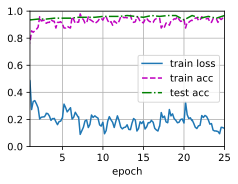

In [6]:
CV.train_fine_tuning(new_model, train_iter, test_iter,
                     learning_rate=1e-3,
                     num_epochs=25,
                     param_group=False,
                     device=device)

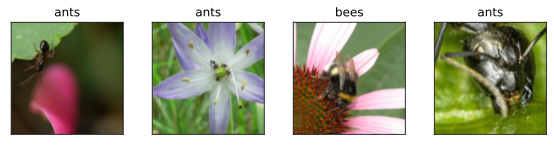

In [7]:
for xs, _ in test_iter:
    break

MT = ModuleTool(xs)
MT.imshow(new_model, loader.class_names, device,
          num_rows=1, num_cols=4, scale=2)
plt.tight_layout()

## 2 微调量化模型

在这一部分中，对用于迁移学习的特征提取器进行了微调，并对特征提取器进行量化。注意，在第 1 部分和第 2 部分中，特征提取器都是量化的。不同之处在于，在第 1 部分中，使用了预训练的量化模型。在这一部分中，我们在对感兴趣的数据集进行微调后，创建了量化的特征提取器，因此这是一种利用迁移学习获得更好准确性的方法，同时具有量化的好处。请注意，在我们的具体示例中，训练集非常小（120 张图片），因此对整个模型进行微调的好处并不明显。然而，这里显示的过程将提高迁移学习的准确性于更大的数据集。

预训练的特征提取器必须是可量化的。要确保它是可量化的，请执行以下步骤：

1. 使用 {func}`torch.quantization.fuse_modules` 融合 ``(Conv, BN, ReLU)``, ``(Conv, BN)`` 和 ``(Conv, ReLU)``。
2. 连接特征提取器与自定义头。这需要反量化特征提取器的输出。
3. 在特征提取器中适当位置插入伪量化模块，训练时模拟量化。

对于步骤（1），我们使用来自 {mod}`torchvision.models.quantization` 的模型 `resnet18`，它们有成员方法 ``fuse_model``。这个函数融合了 ``conv``，``bn`` 和 ``relu`` 模块。对于自定义模型，这将需要调用 {func}`torch.quantization.fuse_modules` API 中包含了需要手动融合的模块列表。

步骤（2）由前一节中使用的 ``create_combined_model`` 函数执行。

步骤（3）通过使用 {func}`torch.quantization.prepare_qat`，插入 fake-quantization 模块。

作为步骤（4），您可以开始“微调”模型，然后将其转换为完全量化的版本（步骤5）。

要将微调模型转换为量化模型，可以调用 {func}`torch.quantization.convert` 函数（在我们的例子中，只有特征提取器被量化）。

```{note}
由于随机初始化，您的结果可能与本教程中显示的结果不同。
```

In [8]:
# 注意 `quantize=False`
model = resnet18(pretrained=True, progress=True, quantize=False)

# Step 1
model.train()
model.fuse_model()
# Step 2
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # 使用默认 QAT 配置
# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)

```{rubric} Step 4. 微调模型
```

在本教程中，对整个模型进行了微调。一般来说，这将导致更高的准确性。但是，由于这里使用的训练集较小，我们最终会对训练集过拟合。

In [9]:
for param in model_ft.parameters():
  param.requires_grad = True

# 如果可用的话，我们可以对 GPU 进行微调
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loss 0.417, train acc 0.832, test acc 0.928
60.5 examples/sec on cuda:0


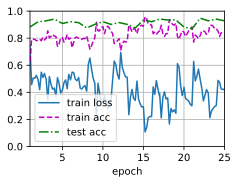

In [10]:
CV.train_fine_tuning(model_ft, train_iter, test_iter,
                     learning_rate=1e-3,
                     num_epochs=25,
                     param_group=False,
                     device=device)

```{rubric} Step 5. 转换已量化的模型
```

In [11]:
from torch.quantization import convert
model_ft.cpu()

model_quantized_and_trained = convert(model_ft, inplace=False)

让我们看看量化模型在一些图像上的表现：

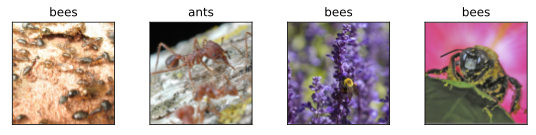

In [12]:
for xs, _ in test_iter:
    break

MT = ModuleTool(xs)
MT.imshow(model_quantized_and_trained,
          loader.class_names,
          'cpu',
          num_rows=1, num_cols=4, scale=2)
plt.tight_layout()
plt.ioff()
plt.tight_layout()
plt.show()